In [27]:
import torch, os
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
import matplotlib.pyplot as plt
from tqdm import tqdm
from einops import rearrange, repeat
import copy
import numpy as np
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D


from torchvision.utils import save_image, make_grid
from torchvision import transforms
from torchvision.datasets import MNIST

from modules.networks.unet import UNetModel

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Use only the first GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1
train_dataset = MNIST("/data/edherron/data/MNIST", train=True, download=False, transform=tf)
# val_dataset = MNIST("/data/edherron/data/MNIST", train=False, download=False, transform=tf)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=256,
                                           shuffle=True,
                                           num_workers=1
                                           )

# val_loader = torch.utils.data.DataLoader(val_dataset, 
#                                         batch_size=256, 
#                                         shuffle=True, 
#                                         drop_last=True, 
#                                         num_workers=1
#                                         )

def pad(tensor):
    return repeat(tensor, 'b -> b 1 1 1')

In [2]:
class RectifiedFlow():
    def __init__(self, model=None, device=None, num_steps=1000):
        self.model = model
        self.model.to(device)
        self.N = num_steps
        self.device = device
        
    def get_train_tuple(self, z0=None, z1=None):
        t = torch.rand((z1.shape[0],)).to(self.device)
        z_t = pad(t) * z1 + (1. - pad(t)) * z0
        target = z1 - z0
        return z_t, t, target
    
    @torch.no_grad()
    def sample_ode(self, z0=None, N=None):
        if N is None:
            N = self.N
        dt = 1./N
        trajectory = []
        z = z0.detach().clone().to(self.device)
        
        
        trajectory.append(z.detach().clone())
        for i in range(N):
            t = torch.ones((z.shape[0],)) * i / N
            t = t.to(self.device)
            pred = self.model(z, t)
            z = z.detach().clone() + pred * dt
            
            trajectory.append(z.detach().clone())
        return trajectory

In [3]:
def train_rectified_flow(data_loader, rectified_flow, opt, device):
    rectified_flow.model.train()
    running_loss = 0.0
    for data in data_loader:
        z1, _ = data
        z1 = z1.to(device)
        # z1 = rearrange(z1.to(device), 'b c h w -> b (c h w)')
        z0 = torch.randn_like(z1).to(device)
        
        z_t, t, target = rectified_flow.get_train_tuple(z0, z1)
        
        pred = rectified_flow.model(z_t, t)
        
        loss = F.mse_loss(pred, target)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        running_loss += loss.item()
    avg_loss = running_loss / len(data_loader)
    return avg_loss

In [4]:
# Init all of our models
model = UNetModel()
RF = RectifiedFlow(model, device)

print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

opt = torch.optim.Adam(model.parameters(), lr=1e-4)

for i in tqdm(range(50)):
    loss_rec = train_rectified_flow(train_loader, RF, opt, device)
    print('loss from epoch ', i, ': ', loss_rec)

Number of parameters:  3607873


  2%|▏         | 1/50 [00:30<24:33, 30.08s/it]

loss from epoch  0 :  0.42306947359379304


  4%|▍         | 2/50 [01:00<24:00, 30.00s/it]

loss from epoch  1 :  0.11132475121858272


  6%|▌         | 3/50 [01:30<23:49, 30.41s/it]

loss from epoch  2 :  0.10182316899299622


  8%|▊         | 4/50 [02:02<23:36, 30.80s/it]

loss from epoch  3 :  0.09878781314225907


 10%|█         | 5/50 [02:34<23:20, 31.12s/it]

loss from epoch  4 :  0.09706060283995689


 12%|█▏        | 6/50 [03:05<22:59, 31.36s/it]

loss from epoch  5 :  0.09557862094742187


 14%|█▍        | 7/50 [03:37<22:33, 31.48s/it]

loss from epoch  6 :  0.09448264574116849


 16%|█▌        | 8/50 [04:09<22:05, 31.56s/it]

loss from epoch  7 :  0.09374771923460859


 18%|█▊        | 9/50 [04:40<21:34, 31.57s/it]

loss from epoch  8 :  0.09284986802872192


 20%|██        | 10/50 [05:12<21:02, 31.55s/it]

loss from epoch  9 :  0.09256153845406594


 22%|██▏       | 11/50 [05:43<20:28, 31.51s/it]

loss from epoch  10 :  0.0913269911357697


 24%|██▍       | 12/50 [06:15<19:55, 31.47s/it]

loss from epoch  11 :  0.09103599311189449


 26%|██▌       | 13/50 [06:46<19:22, 31.42s/it]

loss from epoch  12 :  0.09032229787491737


 28%|██▊       | 14/50 [07:17<18:50, 31.40s/it]

loss from epoch  13 :  0.08995942070763162


 30%|███       | 15/50 [07:49<18:20, 31.45s/it]

loss from epoch  14 :  0.08987682166885823


 32%|███▏      | 16/50 [08:21<17:52, 31.55s/it]

loss from epoch  15 :  0.0893196702637571


 34%|███▍      | 17/50 [08:52<17:20, 31.52s/it]

loss from epoch  16 :  0.08918681696374366


 36%|███▌      | 18/50 [09:24<16:47, 31.48s/it]

loss from epoch  17 :  0.08843358155894787


 38%|███▊      | 19/50 [09:55<16:15, 31.47s/it]

loss from epoch  18 :  0.0879262607782445


 40%|████      | 20/50 [10:26<15:43, 31.45s/it]

loss from epoch  19 :  0.08811423550260827


 42%|████▏     | 21/50 [10:58<15:12, 31.46s/it]

loss from epoch  20 :  0.08802409229126383


 44%|████▍     | 22/50 [11:29<14:41, 31.47s/it]

loss from epoch  21 :  0.08767943008148923


 46%|████▌     | 23/50 [12:01<14:09, 31.48s/it]

loss from epoch  22 :  0.08808167082198123


 48%|████▊     | 24/50 [12:32<13:38, 31.47s/it]

loss from epoch  23 :  0.08749603121838671


 50%|█████     | 25/50 [13:04<13:09, 31.57s/it]

loss from epoch  24 :  0.08707047504313449


 52%|█████▏    | 26/50 [13:36<12:37, 31.58s/it]

loss from epoch  25 :  0.08712251043700157


 54%|█████▍    | 27/50 [14:07<12:06, 31.57s/it]

loss from epoch  26 :  0.08696539018382417


 56%|█████▌    | 28/50 [14:39<11:34, 31.55s/it]

loss from epoch  27 :  0.08710294112246088


 58%|█████▊    | 29/50 [15:10<11:02, 31.54s/it]

loss from epoch  28 :  0.08687499159194054


 60%|██████    | 30/50 [15:42<10:30, 31.52s/it]

loss from epoch  29 :  0.086526905063619


 62%|██████▏   | 31/50 [16:13<09:58, 31.53s/it]

loss from epoch  30 :  0.08661492612767727


 64%|██████▍   | 32/50 [16:45<09:27, 31.54s/it]

loss from epoch  31 :  0.08647244797742114


 66%|██████▌   | 33/50 [17:16<08:55, 31.52s/it]

loss from epoch  32 :  0.08621631011049798


 68%|██████▊   | 34/50 [17:48<08:24, 31.50s/it]

loss from epoch  33 :  0.08615248843710473


 70%|███████   | 35/50 [18:19<07:51, 31.46s/it]

loss from epoch  34 :  0.08594998086386539


 72%|███████▏  | 36/50 [18:50<07:19, 31.42s/it]

loss from epoch  35 :  0.08595844196512344


 74%|███████▍  | 37/50 [19:22<06:48, 31.44s/it]

loss from epoch  36 :  0.08601338688997512


 76%|███████▌  | 38/50 [19:53<06:17, 31.43s/it]

loss from epoch  37 :  0.0860778568272895


 78%|███████▊  | 39/50 [20:25<05:45, 31.44s/it]

loss from epoch  38 :  0.08548131477325521


 80%|████████  | 40/50 [20:56<05:14, 31.43s/it]

loss from epoch  39 :  0.08566665218231526


 82%|████████▏ | 41/50 [21:28<04:42, 31.41s/it]

loss from epoch  40 :  0.08529622697449744


 84%|████████▍ | 42/50 [21:59<04:11, 31.40s/it]

loss from epoch  41 :  0.0851520484115215


 86%|████████▌ | 43/50 [22:30<03:39, 31.40s/it]

loss from epoch  42 :  0.08535960278612502


 88%|████████▊ | 44/50 [23:02<03:08, 31.39s/it]

loss from epoch  43 :  0.08516304397836645


 90%|█████████ | 45/50 [23:33<02:36, 31.39s/it]

loss from epoch  44 :  0.08549364450130056


 92%|█████████▏| 46/50 [24:05<02:05, 31.40s/it]

loss from epoch  45 :  0.08519942731933391


 94%|█████████▍| 47/50 [24:36<01:34, 31.43s/it]

loss from epoch  46 :  0.08510664124438103


 96%|█████████▌| 48/50 [25:07<01:02, 31.43s/it]

loss from epoch  47 :  0.08479815610545746


 98%|█████████▊| 49/50 [25:39<00:31, 31.43s/it]

loss from epoch  48 :  0.08459791873997831


100%|██████████| 50/50 [26:10<00:00, 31.42s/it]

loss from epoch  49 :  0.08500495277186658


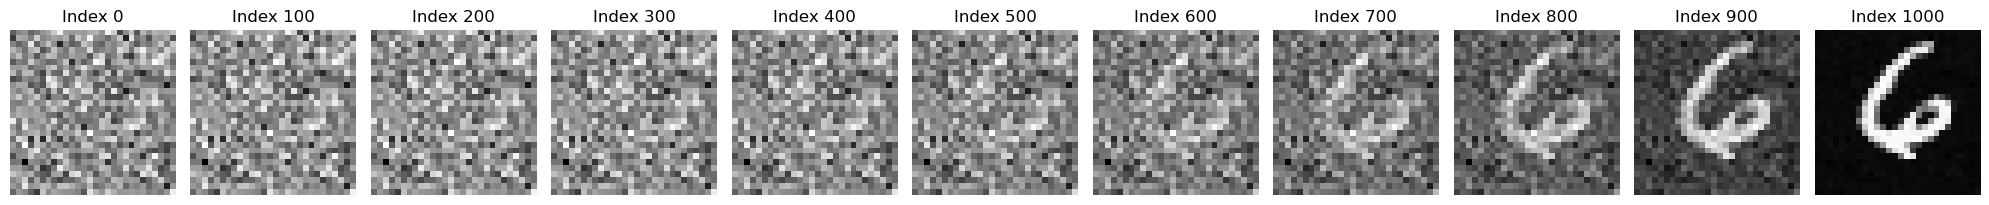

In [5]:
z = torch.randn((1,1,28,28))
trajectory = RF.sample_ode(z0 = z)

# Assuming `data_list` is your list of tensors
fig, axs = plt.subplots(1, 11, figsize=(20, 2))  # Adjust figsize as needed

for i, ax in enumerate(axs.flat):
    idx = i * 100  # Every 100th element
    if idx < len(trajectory):
        img = trajectory[idx].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
        ax.imshow(img, cmap='gray')  # Plot as grayscale image
        ax.set_title(f'Index {idx}')
        ax.axis('off')
    else:
        ax.axis('off')  # Hide axes for plots beyond the list length

plt.tight_layout()
plt.show()


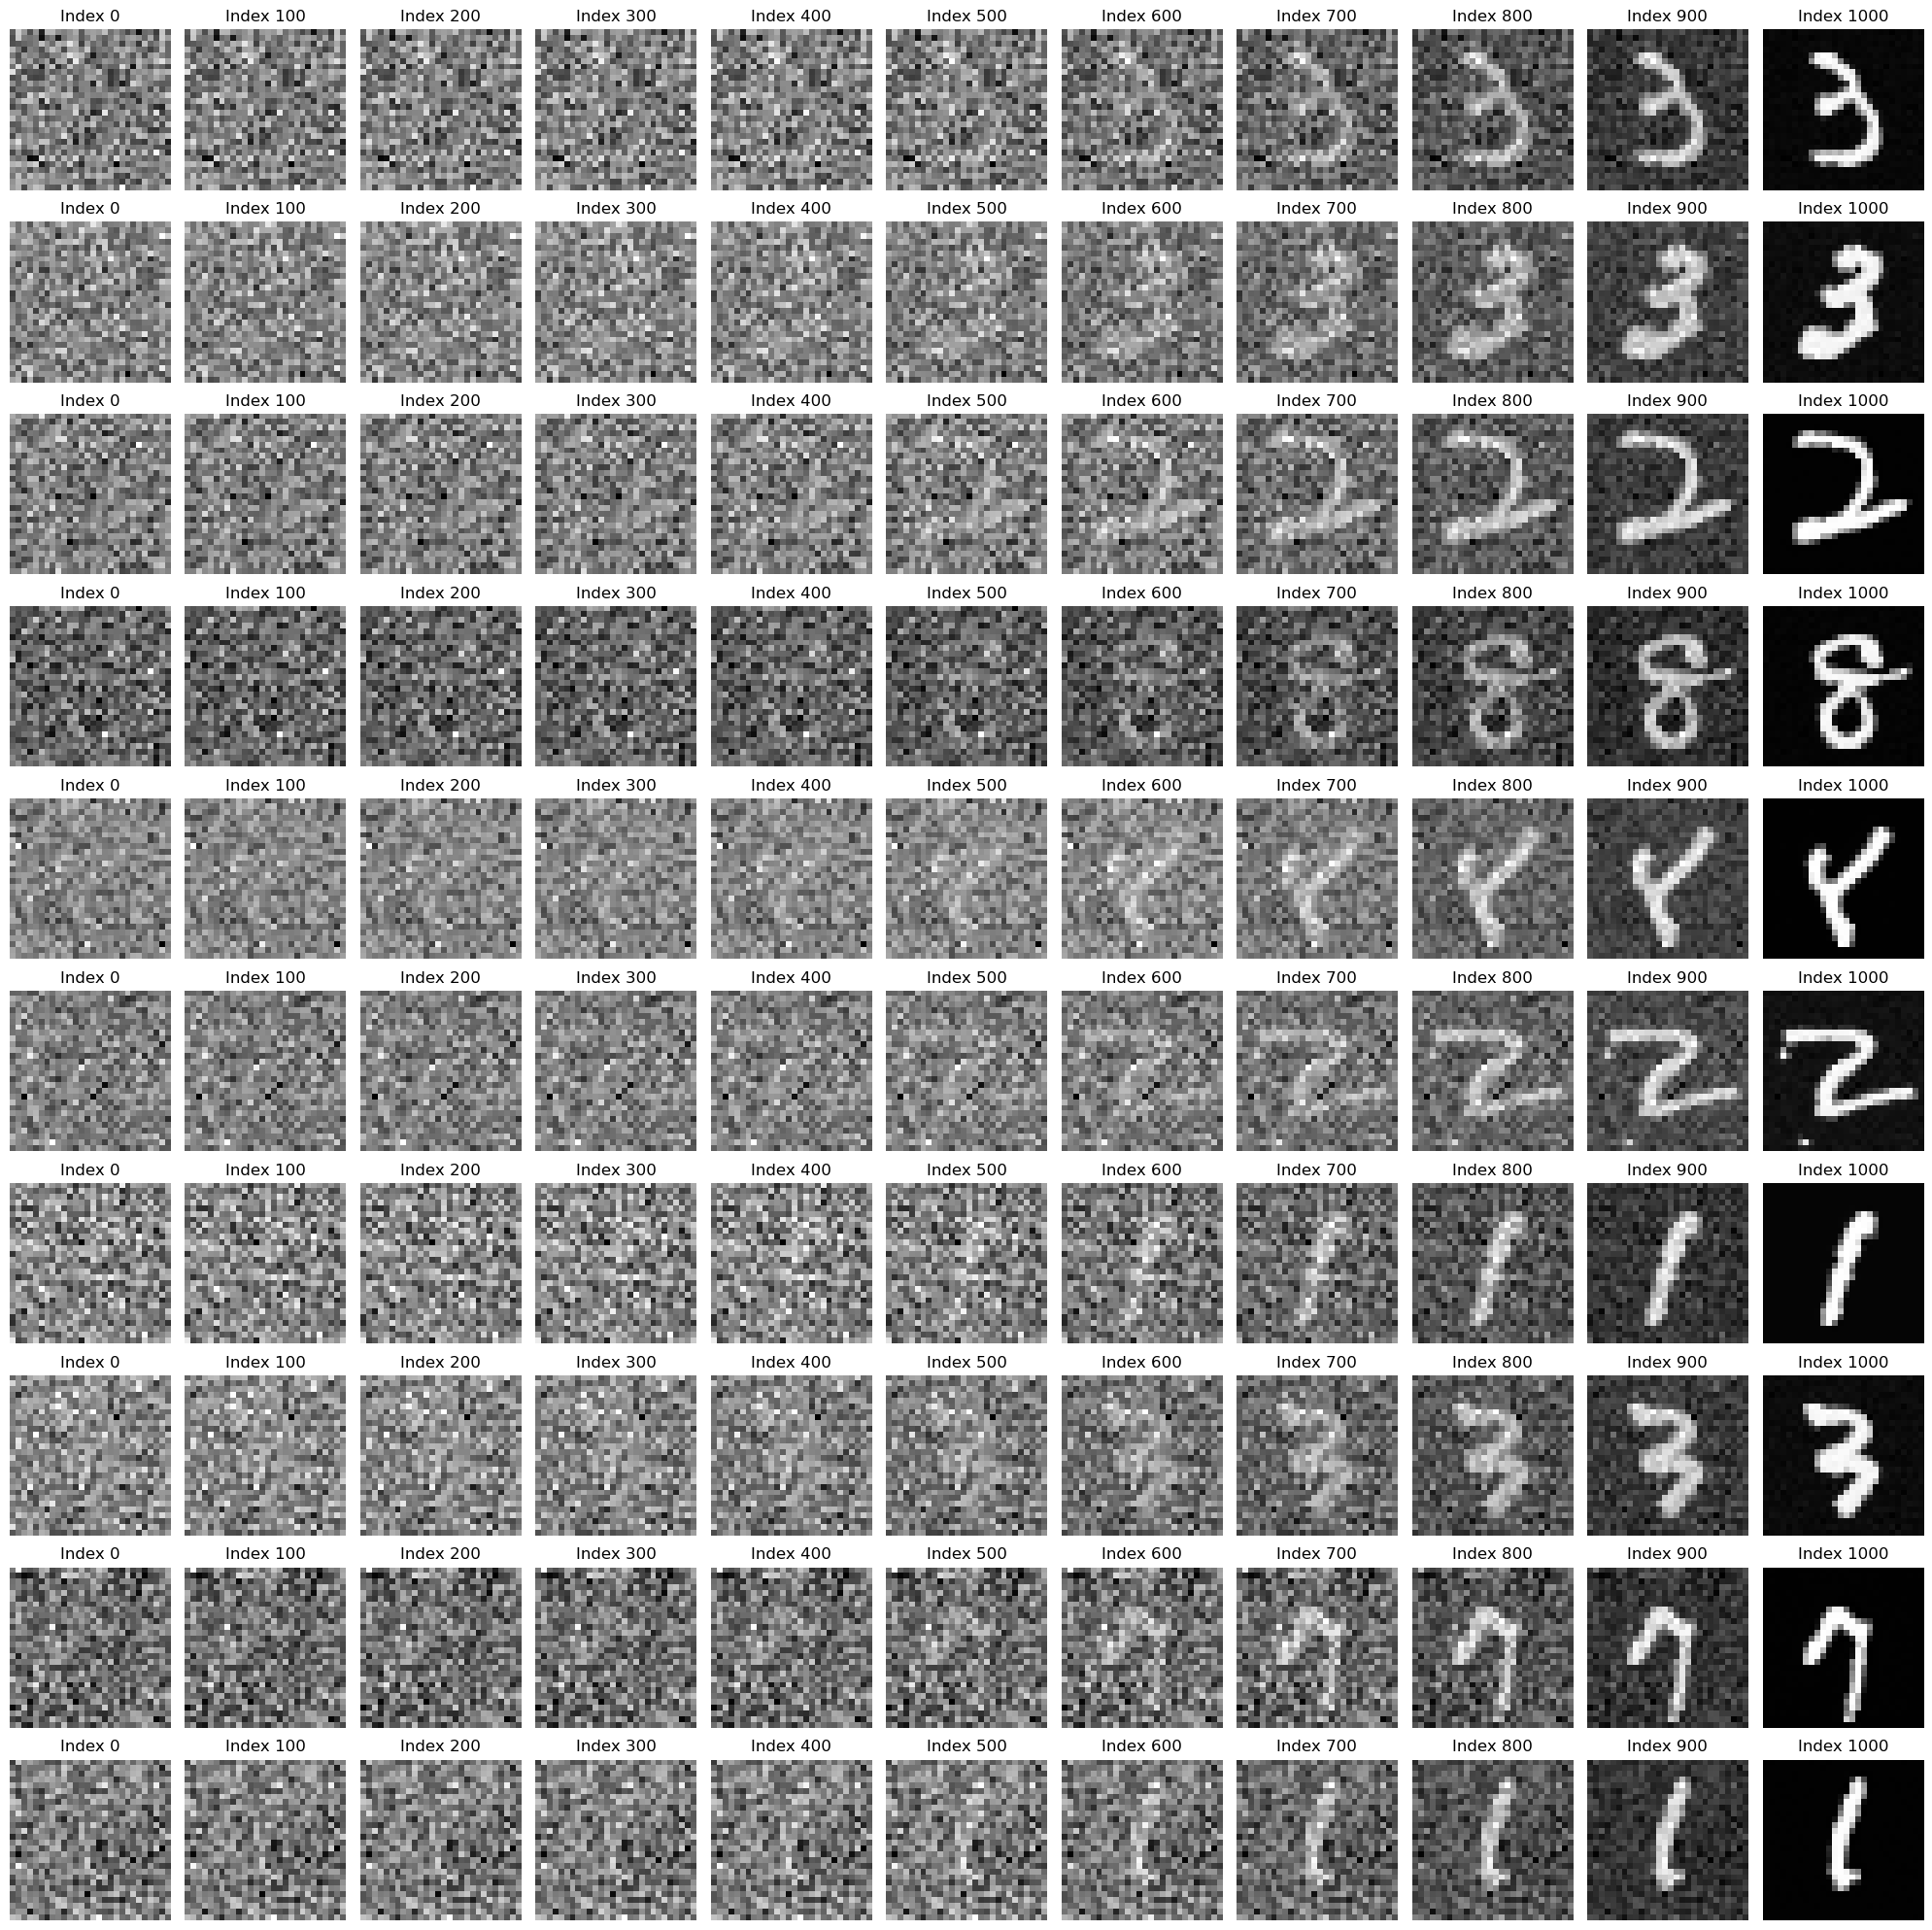

In [6]:
z = torch.randn((10, 1, 28, 28))
trajectories = [RF.sample_ode(z0=z[i].unsqueeze(0)) for i in range(10)]

# Set up the plot for 10 rows of trajectories, each with 11 time steps (same as the column convention)
fig, axs = plt.subplots(10, 11, figsize=(20, 20))  # Adjust figsize as needed, ensure there's enough space

for row, trajectory in enumerate(trajectories):
    for col, ax in enumerate(axs[row]):
        idx = col * 100  # Every 100th element as in the original convention
        if idx < len(trajectory):
            img = trajectory[idx].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
            ax.imshow(img, cmap='gray')  # Plot as grayscale image
            ax.set_title(f'Index {idx}')
            ax.axis('off')
        else:
            ax.axis('off')  # Hide axes for plots beyond the list length

plt.tight_layout()
plt.show()

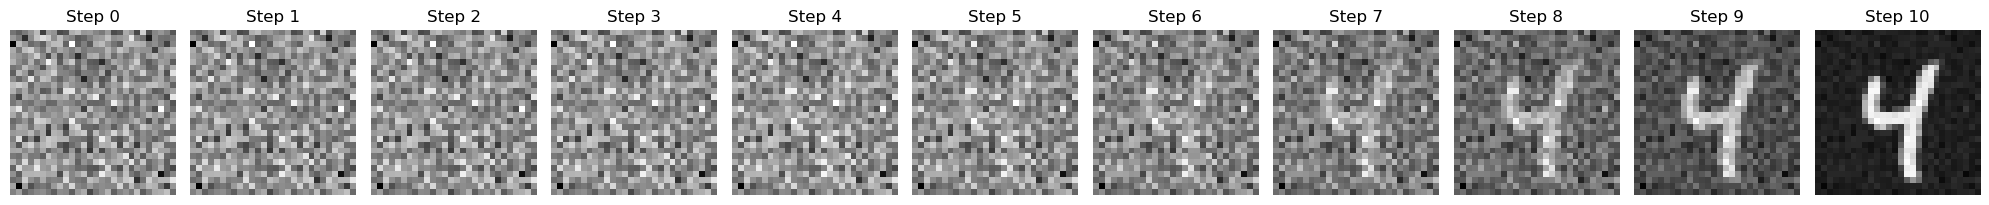

In [7]:
z = torch.randn((1, 1, 28, 28))
trajectory = RF.sample_ode(z0 = z, N = 10)  # This should give a trajectory with 11 tensors including the initial condition

# Assuming trajectory is your list of tensors with exactly 11 elements
fig, axs = plt.subplots(1, 11, figsize=(20, 2))  # Adjust figsize as needed

for idx, ax in enumerate(axs.flat):
    if idx < len(trajectory):
        img = trajectory[idx].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
        ax.imshow(img, cmap='gray')  # Plot as grayscale image
        ax.set_title(f'Step {idx}')
        ax.axis('off')
    else:
        ax.axis('off')  # Hide axes for plots beyond the list length

plt.tight_layout()
plt.show()

# Rectified Flow 2 model.
Here we take the pretrained RF model above and fine tune it on DETERMINISTIC pairs of z_0 and z_1. By randomly sampling z_0 and generating a new sample z_1 with the sampled z_0. 

In [11]:
z10 = []
z11 = []

for _ in range(10):  # The loop runs 10 times
    z = torch.randn((512, 1, 28, 28))  # Generate a new z of the specified size
    trajectory = RF.sample_ode(z0 = z, N = 10)  # Compute the trajectory

    # Assuming the trajectory output is a list of 11 tensors for each z in the batch
    z10.extend(trajectory[0])  # Extend z10 with the first tensors of each trajectory
    z11.extend(trajectory[-1])  # Extend z11 with the last tensors of each trajectory

# Check the lengths, should each be 10*512
print("Length of z10:", len(z10))
print("Length of z11:", len(z11))

z10_tensor = torch.stack(z10)  # Stack all tensors in z10 to create one tensor
z11_tensor = torch.stack(z11)  # Stack all tensors in z11 to create one tensor

print("z10 tensor shape:", z10_tensor.shape)
print("z11 tensor shape:", z11_tensor.shape)

z1_pairs = torch.stack([z10_tensor, z11_tensor], dim=1)
print("z1_pairs shape: ", z1_pairs.shape)

Length of z10: 5120
Length of z11: 5120
z10 tensor shape: torch.Size([5120, 1, 28, 28])
z11 tensor shape: torch.Size([5120, 1, 28, 28])
z1_pairs shape:  torch.Size([5120, 2, 1, 28, 28])


In [17]:
def train_rectified_flow_2(inner_iters, rectified_flow, opt, device):
    rectified_flow.model.train()
    running_loss = 0.0
    for _ in tqdm(range(inner_iters)):
        indices = torch.randperm(len(z10))[:64]
        batch = z1_pairs[indices]
        z0 = batch[:, 0].detach().clone()
        z1 = batch[:, 1].detach().clone()
        z0 = z0.to(device)
        z1 = z1.to(device)
        
        z_t, t, target = rectified_flow.get_train_tuple(z0, z1)
        
        pred = rectified_flow.model(z_t, t)
        
        loss = F.mse_loss(pred, target)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        running_loss += loss.item()
    avg_loss = running_loss / len(z10)
    return avg_loss

In [19]:
RF_2 = RectifiedFlow(model=UNetModel(), device=device, num_steps=100)
RF_2.model = copy.deepcopy(RF.model)
optimizer = torch.optim.Adam(RF_2.model.parameters(), lr=1e-4)

loss_rec = train_rectified_flow_2(len(z10), RF_2, optimizer, device)
print('loss from epoch ', i, ': ', loss_rec)

100%|██████████| 5120/5120 [05:04<00:00, 16.83it/s]

loss from epoch  0 :  0.009976370918138855


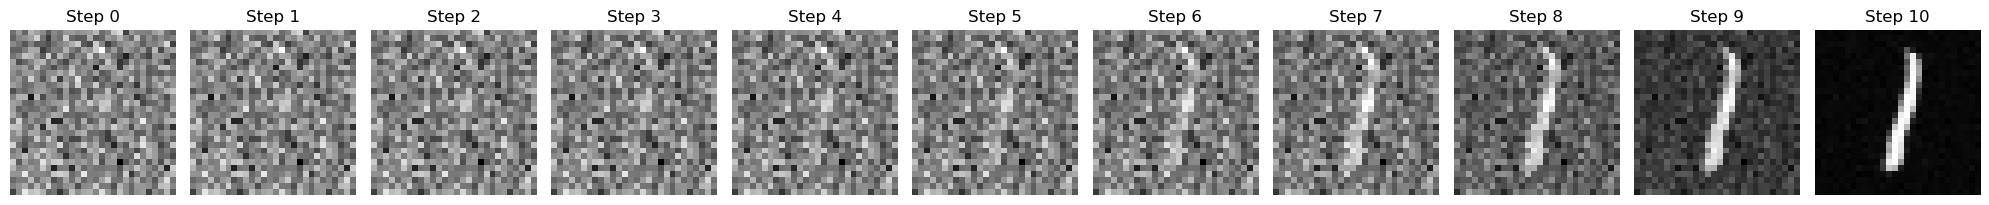

In [20]:
z = torch.randn((1, 1, 28, 28))
trajectory = RF_2.sample_ode(z0 = z, N = 10)  # This should give a trajectory with 11 tensors including the initial condition

# Assuming trajectory is your list of tensors with exactly 11 elements
fig, axs = plt.subplots(1, 11, figsize=(20, 2))  # Adjust figsize as needed

for idx, ax in enumerate(axs.flat):
    if idx < len(trajectory):
        img = trajectory[idx].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
        ax.imshow(img, cmap='gray')  # Plot as grayscale image
        ax.set_title(f'Step {idx}')
        ax.axis('off')
    else:
        ax.axis('off')  # Hide axes for plots beyond the list length

plt.tight_layout()
plt.show()

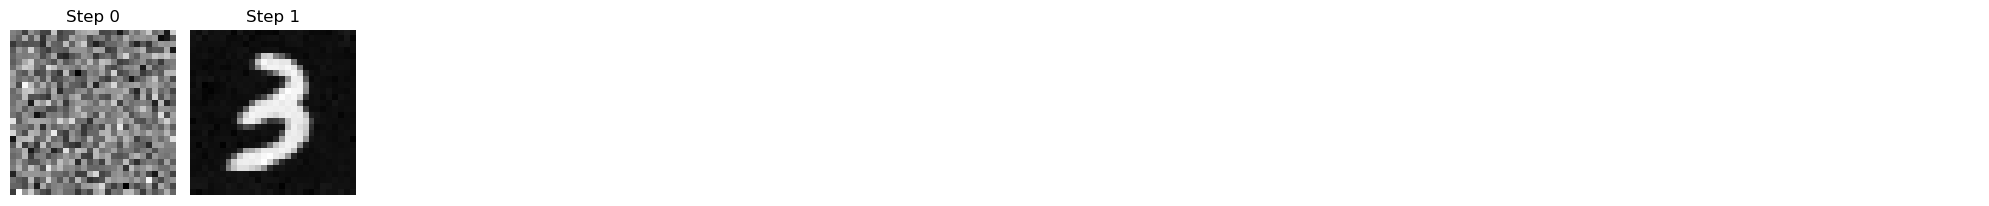

In [34]:
z = torch.randn((1, 1, 28, 28))
trajectory = RF_2.sample_ode(z0 = z, N = 1)  # This should give a trajectory with 11 tensors including the initial condition

# Assuming trajectory is your list of tensors with exactly 11 elements
fig, axs = plt.subplots(1, 11, figsize=(20, 2))  # Adjust figsize as needed

for idx, ax in enumerate(axs.flat):
    if idx < len(trajectory):
        img = trajectory[idx].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
        ax.imshow(img, cmap='gray')  # Plot as grayscale image
        ax.set_title(f'Step {idx}')
        ax.axis('off')
    else:
        ax.axis('off')  # Hide axes for plots beyond the list length

plt.tight_layout()
plt.show()

In [21]:
z20 = []
z21 = []

for _ in range(10):  # The loop runs 10 times
    z = torch.randn((512, 1, 28, 28))  # Generate a new z of the specified size
    trajectory = RF.sample_ode(z0 = z, N = 10)  # Compute the trajectory

    # Assuming the trajectory output is a list of 11 tensors for each z in the batch
    z20.extend(trajectory[0])  # Extend z20 with the first tensors of each trajectory
    z21.extend(trajectory[-1])  # Extend z21 with the last tensors of each trajectory

# Check the lengths, should each be 10*512
print("Length of z20:", len(z20))
print("Length of z21:", len(z21))

z20_tensor = torch.stack(z20)  # Stack all tensors in z20 to create one tensor
z21_tensor = torch.stack(z21)  # Stack all tensors in z21 to create one tensor

print("z20 tensor shape:", z20_tensor.shape)
print("z21 tensor shape:", z21_tensor.shape)


Length of z20: 5120
Length of z21: 5120
z20 tensor shape: torch.Size([5120, 1, 28, 28])
z21 tensor shape: torch.Size([5120, 1, 28, 28])


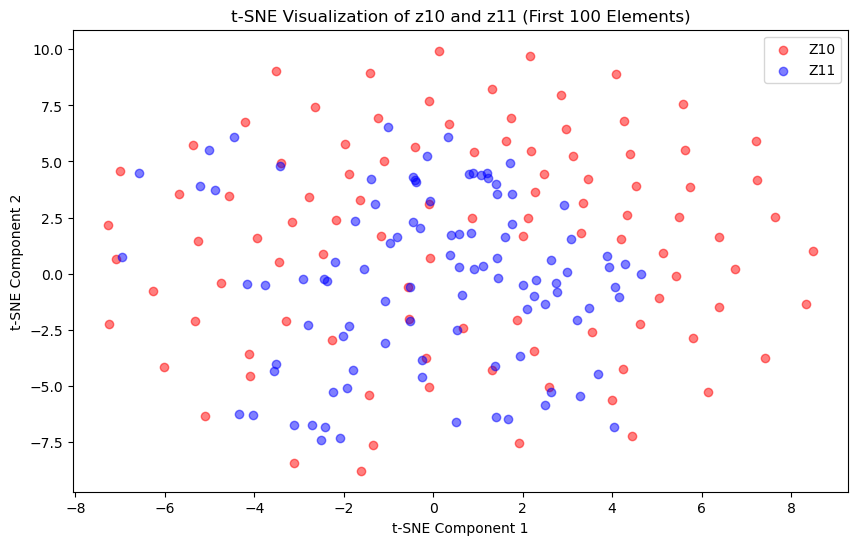

In [26]:
# Assuming z10_tensor and z11_tensor are already created
# Select the first 100 elements from each tensor
z10_subset = z10_tensor[:100].detach().cpu().numpy()
z11_subset = z11_tensor[:100].detach().cpu().numpy()

# Flatten the tensors from [100, 1, 28, 28] to [100, 784]
z10_flat = z10_subset.reshape(z10_subset.shape[0], -1)
z11_flat = z11_subset.reshape(z11_subset.shape[0], -1)

# Combine z10 and z11 for TSNE processing using numpy.concatenate
combined_data = np.concatenate((z10_flat, z11_flat), axis=0)

# Initialize and fit TSNE
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(combined_data)

# Split the results back into z10 and z11 parts
tsne_z10 = tsne_results[:z10_flat.shape[0], :]
tsne_z11 = tsne_results[z10_flat.shape[0]:, :]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(tsne_z10[:, 0], tsne_z10[:, 1], c='red', label='Z10', alpha=0.5)
plt.scatter(tsne_z11[:, 0], tsne_z11[:, 1], c='blue', label='Z11', alpha=0.5)
plt.title('t-SNE Visualization of z10 and z11 (First 100 Elements)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

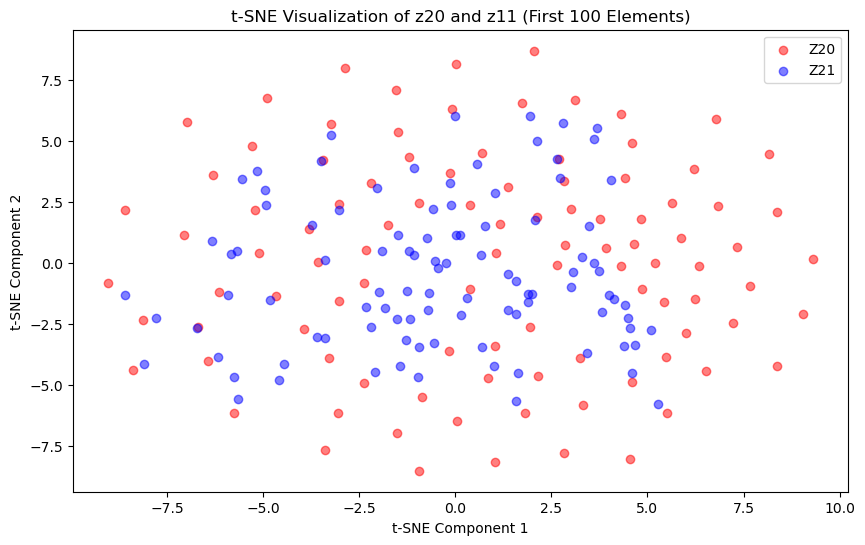

In [29]:
# Assuming z10_tensor and z11_tensor are already created
# Select the first 100 elements from each tensor
z20_subset = z20_tensor[:100].detach().cpu().numpy()
z21_subset = z21_tensor[:100].detach().cpu().numpy()

# Flatten the tensors from [100, 1, 28, 28] to [100, 784]
z20_flat = z20_subset.reshape(z20_subset.shape[0], -1)
z21_flat = z21_subset.reshape(z21_subset.shape[0], -1)

# Combine z20 and z21 for TSNE processing using numpy.concatenate
combined_data = np.concatenate((z20_flat, z21_flat), axis=0)

# Initialize and fit TSNE
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(combined_data)

# Split the results back into z20 and z21 parts
tsne_z20 = tsne_results[:z20_flat.shape[0], :]
tsne_z21 = tsne_results[z20_flat.shape[0]:, :]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(tsne_z20[:, 0], tsne_z20[:, 1], c='red', label='Z20', alpha=0.5)
plt.scatter(tsne_z21[:, 0], tsne_z21[:, 1], c='blue', label='Z21', alpha=0.5)
plt.title('t-SNE Visualization of z20 and z11 (First 100 Elements)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()